# Problem Set 1: Edges and Lines

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

## Question 1 - Store Edge Image

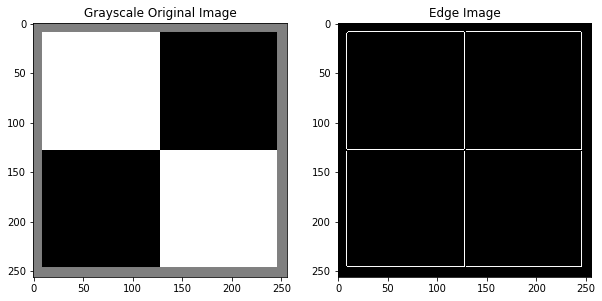

True

In [2]:
# Loads an image
image_grayscale = cv.imread("input/ps1-input0.png", cv.IMREAD_GRAYSCALE)

# Edge detection using Canny
edge_image = cv.Canny(
   image=image_grayscale,
   threshold1=50,
   threshold2=200,
   edges=None,
   apertureSize=3
)

fig, axs = plt.subplots(ncols=2, figsize=(10, 10), facecolor="white")
axs[0].imshow(image_grayscale, cmap="gray"), axs[0].set_title("Grayscale Original Image")
axs[1].imshow(edge_image, cmap="gray"), axs[1].set_title("Edge Image")
plt.show()

cv.imwrite("output/ps1-1-a-1.png", edge_image)

## Question 2 - Implementing Hough Transform
### a) Write a function hough_lines_acc that computes the Hough Transform for lines and produces an accumulator array.
Output: Store the hough accumulator array (H) as ps1-2-a-1.png (note: write a normalized uint8 version of the array
so that the minimum value is mapped to 0 and maximum to 255).

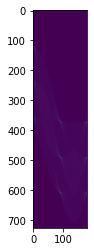

True

In [3]:
def hough_lines_acc(image, rho_resolution=1, theta_resolution=1):
    """ Hough Accumulator for lines in an image. """
    height, width = image.shape
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # create the empty Hough Accumulator with dimensions equal to the size of rhos and thetas
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(image) # find all edge (nonzero) pixel indexes

    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]

        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int(x * np.cos(thetas[j]) + y * np.sin(thetas[j]) + img_diagonal)
            H[rho, j] += 1

    return H, rhos, thetas

H, rhos, thetas = hough_lines_acc(edge_image)
plt.figure(facecolor='white')
plt.imshow(H)
plt.show()

cv.imwrite('output/ps1-2-a-1.png', H)

### b) Write a function hough_peaks that finds indices of the accumulator array (here line parameters) that correspond to local maxima.
Output: ps1-2-b-1.png.

In [4]:
def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    """ A function that returns the indicies of the accumulator array H that
        correspond to a local maxima.  If threshold is active all values less
        than this value will be ignored, if neighborhood_size is greater than
        (1, 1) this number of indicies around the maximum will be surpassed. """
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        # surpass indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size/2)) < 0:
           min_x = 0
        else:
           min_x = idx_x - (nhood_size/2)
        if (idx_x + (nhood_size / 2) + 1) > H.shape[1]:
           max_x = H.shape[1]
        else:
           max_x = idx_x + (nhood_size/2) + 1

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size/2)) < 0:
           min_y = 0
        else:
           min_y = idx_y - (nhood_size/2)
        if (idx_y + (nhood_size / 2) + 1) > H.shape[0]:
           max_y = H.shape[0]
        else:
           max_y = idx_y + (nhood_size/2) + 1

        # bound each index by the neighborhood size and set all values to 0
        for x in range(int(min_x), int(max_x)):
            for y in range(int(min_y), int(max_y)):
                # remove neighborhoods in H1
                H1[y, x] = 0

                # highlight peaks in original H
                if x == min_x or x == (max_x - 1):
                    H[y, x] = 255
                if y == min_y or y == (max_y - 1):
                    H[y, x] = 255

    # return the indicies and the original Hough space with selected points
    return indicies, H

indices, H = hough_peaks(H, num_peaks=10)
indices

[(118, 0),
 (608, 90),
 (236, 0),
 (490, 90),
 (355, 0),
 (371, 90),
 (121, 1),
 (239, 1),
 (374, 91),
 (374, 179)]

### c) Write a function hough_lines_draw to draw color lines that correspond to peaks found in the accumulator array.
Output: ps1-2-c-1.png - can be saved as a plot directly from hough_lines_draw().

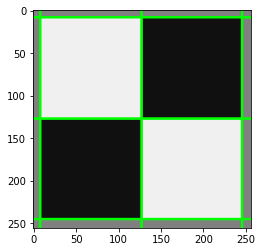

True

In [5]:
# drawing the lines from the Hough Accumulator lines using OpevCV cv2.line
def hough_lines_draw(img, indicies, rhos, thetas):
    """ A function that takes indicies a rhos table and thetas table and draws
        lines on the input images that correspond to these values. """
    for i in range(len(indicies)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

H, rhos, thetas = hough_lines_acc(edge_image)
indicies, H = hough_peaks(H, 6, nhood_size=11) # find peaks

original_image = cv.imread('input/ps1-input0.png')
hough_lines_draw(original_image, indicies, rhos, thetas)

plt.figure(facecolor='white')
plt.imshow(original_image)
plt.show()

cv.imwrite('output/ps1-2-c-1.png', original_image)

### d) What parameters did you use for finding lines in this image?
Output: Text response describing your accumulator bin sizes, threshold and neighborhood
size parameters for finding peaks, and why/how you picked those.

## 3. Add some noise
### a) Use ps1-input0-noise.png - same image as before, but with noise. Compute a modestly smoothed version of this image by using a Gaussian filter. Make σ at least a few pixels big.
    Output: Smoothed image: ps1-3-a-1.png

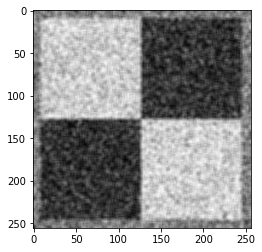

True

In [42]:
image_with_noise = cv.imread("input/ps1-input0-noise.png", cv.IMREAD_GRAYSCALE)
image_smoothed = cv.GaussianBlur(image_with_noise, ksize=(5, 5), sigmaX=5)
plt.figure(facecolor='white')
plt.imshow(image_smoothed, cmap='gray')
# plt.imshow(image_with_noise)
plt.show()
cv.imwrite('output/ps1-3-a-1.png', image_smoothed)

### b) Using an edge operator of your choosing, create a binary edge image for both the original image (ps1-input0-noise.png) and the smoothed version above.
    Output: Two edge images: ps1-3-b-1.png (from original), ps1-3-b-2.png (from smoothed)

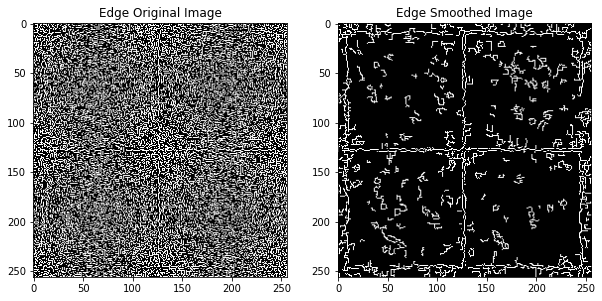

True

In [44]:
# Edge detection using Canny
edge_noisy_image = cv.Canny(
   image=image_with_noise,
   threshold1=100,
   threshold2=200,
   edges=None,
   apertureSize=3
)

edge_smoothed_image = cv.Canny(
   image=image_smoothed,
   threshold1=100,
   threshold2=200,
   edges=None,
   apertureSize=3
)

fig, axs = plt.subplots(ncols=2, figsize=(10, 10), facecolor="white")
axs[0].imshow(edge_noisy_image, cmap="gray"), axs[0].set_title("Edge Original Image")
axs[1].imshow(edge_smoothed_image, cmap="gray"), axs[1].set_title("Edge Smoothed Image")
plt.show()

cv.imwrite("output/ps1-3-b-1.png", edge_noisy_image)
cv.imwrite("output/ps1-3-b-2.png", edge_smoothed_image)

### c) Now apply your Hough method to the smoothed version of the edge image. Your goal is to adjust the filtering, edge finding, and Hough algorithms to find the lines as best you can in this test case.
    Output:
        - Hough accumulator array image with peaks highlighted: ps1-3-c-1.png
        - Intensity image (original one with the noise) with lines drawn on them: ps1-3-c-2.png
        - Text response: Describe what you had to do to get the best result you could.